In [1]:
import sys
import os
import numpy as np
import pandas as pd
from glob import glob
from scipy.signal import ricker
from scipy.optimize import minimize

In [3]:
sys.path.append('../../../repos/seismiqb/')
from seismiqb import Well, OptimizationMixin, ImpulseOptimizationFactory, show_wavelet, symmetric_wavelet_estimation
from seismiqb import plot, Field

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

## Open and filter log

* selecting the well and fetching its coordinates

In [9]:
cube_path = '/data/seismic_data/seismic_interpretation/105_ZAPZIP/105_ZAPZIM_CLEANED.sgy'
coordinates_path = '/data/seismic_data/seismic_interpretation/105_ZAPZIP/Well/Coordinates/Coordinates_wells.txt'
well_paths_mask = '/data/seismic_data/seismic_interpretation/105_ZAPZIP/Well/LAS/*'
well_number = 3

field = Field(cube_path)
geometry = field.geometry

coordinates_df = pd.read_csv(coordinates_path, sep='\s+', encoding='1251')

In [10]:
coordinates_df.head(3)

,N_skv,NAME,CAT,Alt,X_utm42,Y_utm42
0,Zim-1,Зимняя,ПО,47.40,250656.72,3306957.23
1,Zim-3,Зимняя,P,50.08,253660.16,3308975.05
2,Zim-6,Зимняя,P,49.92,253307.18,3309244.28


In [11]:
coordinates = coordinates_df[['X_utm42', 'Y_utm42']].values
ordinal_coordinates = geometry.cdp_to_lines(coordinates).astype(np.int32) - geometry.shifts
name_to_coordinate = dict(zip(coordinates_df['N_skv'], ordinal_coordinates))

* loading selected well

In [21]:
well_paths = sorted(glob(well_paths_mask))

well_path = well_paths[well_number]
well_name = os.path.basename(well_path)

well_coordinates = name_to_coordinate[well_name].tolist()
well_slice = (*well_coordinates, slice(0, geometry.shape[-1]))

# load also the seismic trace from the well location
seismic_curve = geometry[well_slice]

In [22]:
well = Well(storage=well_path, field=field)

* get filtered version of ai

In [23]:
# Remember mask of nans - where either RHOB or DT is nan.
nan_mask = np.isnan(well.DT) | np.isnan(well.RHOB)

# Filter
well.RHOB = well.RHOB.fillna(method='bfill').fillna(method='ffill')
well.DT = well.DT.fillna(method='bfill').fillna(method='ffill')

In [24]:
# Converting units and filtering sonic log
well['DT_FILTERED'] = well.lowpass_filter(well.DT, pad_width=None, forward_backward=True)
well.microseconds_foot_to_seconds_meter(sonic_log='DT_FILTERED', name='DT_SECONDS_METER')

# Converting units and filtering for density log
well['RHOB_FILTERED'] = well.lowpass_filter(well.RHOB, pad_width=0, forward_backward=True)
well.gramm_centimeter3_to_kilogramm_meter3(density_log='RHOB_FILTERED', name='RHOB_FILTERED')

In [25]:
# Compute impedance and convert it
well.compute_impedance_log_in_pascal_meter(sonic_log='DT_SECONDS_METER', density_log='RHOB_FILTERED')
well.pascal_meter_to_kilopascal_meter(name='AI_FILTERED')

In [28]:
# Apply nans to the computed impedance - needed to correctly calculate correlation to measure match later
well.AI_FILTERED[nan_mask] = np.nan

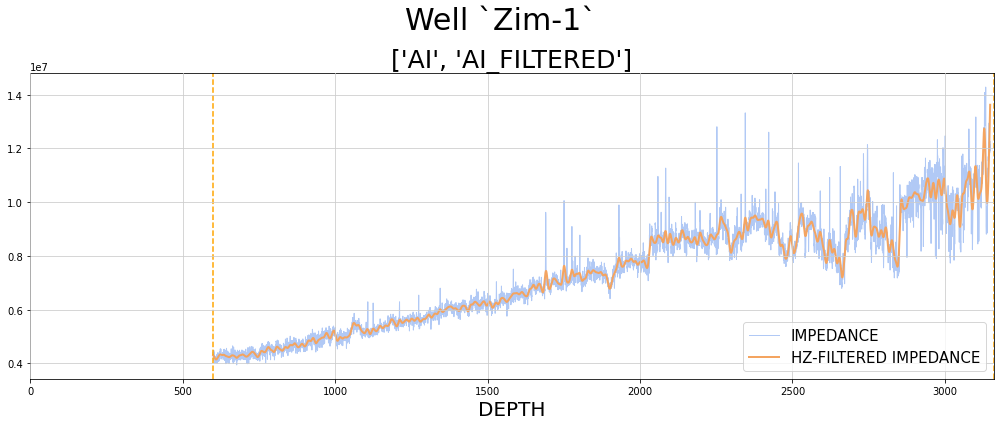

In [29]:
well.plot(logs=['AI', 'AI_FILTERED'], combine='overlay', window=None, figsize=(14, 6),
          curve_alpha=[.5, 1], curve_linewidth=[1, 2], label=['IMPEDANCE', 'HZ-FILTERED IMPEDANCE'])

# 

* cast filtered log into seismic time, generate synthetic out of it and compare with original seismic

In [30]:
def resample_and_compute_synthetic(seismic_time, well_time, impedance, impulse):
    """ Small helper to generate the synthetic out of raw log of impedance. """
    resampled_impedance = well.resample_log(seismic_time, well_time, impedance)
    recreated = well.compute_synthetic_(impedance=resampled_impedance, impulse=impulse)
    return recreated

In [31]:
# Compute seismic time in seconds
seismic_time = np.arange(0.0, geometry.depth * geometry.sample_interval * 1e-3, geometry.sample_interval * 1e-3)

In [32]:
# Compute assumed well time in seconds
well_time = np.cumsum(well.DT_FILTERED.values * 1e-6)
raw_impedance = well['AI_FILTERED'].values

In [33]:
# Resample log and recreate synthetic
recreated = resample_and_compute_synthetic(seismic_time, well_time, raw_impedance, impulse=4 * ricker(60, 4.3))

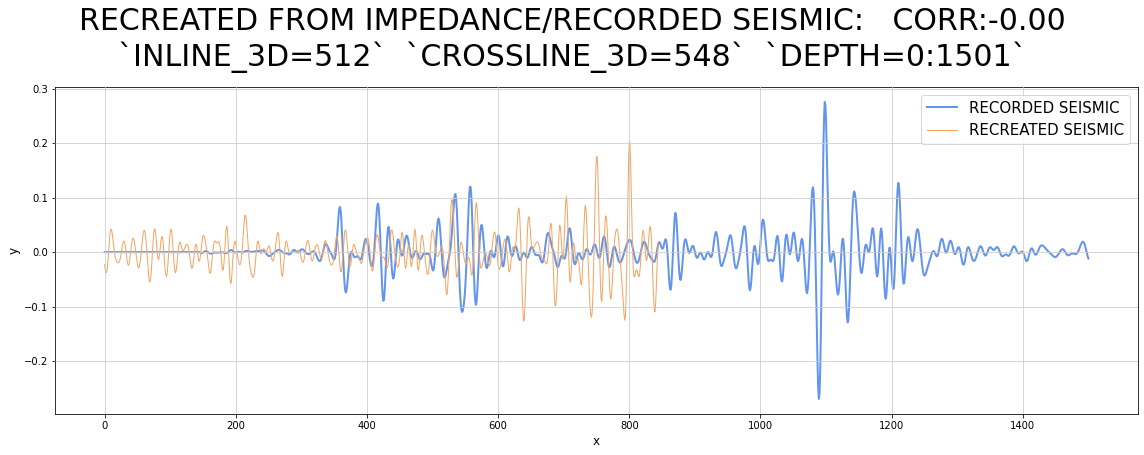

In [34]:
# Use this picture to find out rough bounds for needed shift
correlation = well.nancorrelation(recreated, seismic_curve)

suptitle = (f'RECREATED FROM IMPEDANCE/RECORDED SEISMIC:   CORR:{correlation:.2f}\n`INLINE_3D={well_slice[0]}`  '
            f'`CROSSLINE_3D={well_slice[1]}`  `DEPTH={well_slice[2].start}:{well_slice[2].stop}`')

plot([seismic_curve, recreated],
     mode='curve', ratio=0.4,
     curve_linewidth=[2, 1, 1],
     suptitle=suptitle,
     label=['RECORDED SEISMIC', 'RECREATED SEISMIC'])

In [36]:
# We can clearly see that there exists an unknown shift that we need to determine
# Let's make it happen by improving the wavelet estimation and the looking at crocccorrelation plot

## Symmetric wavelet estimation

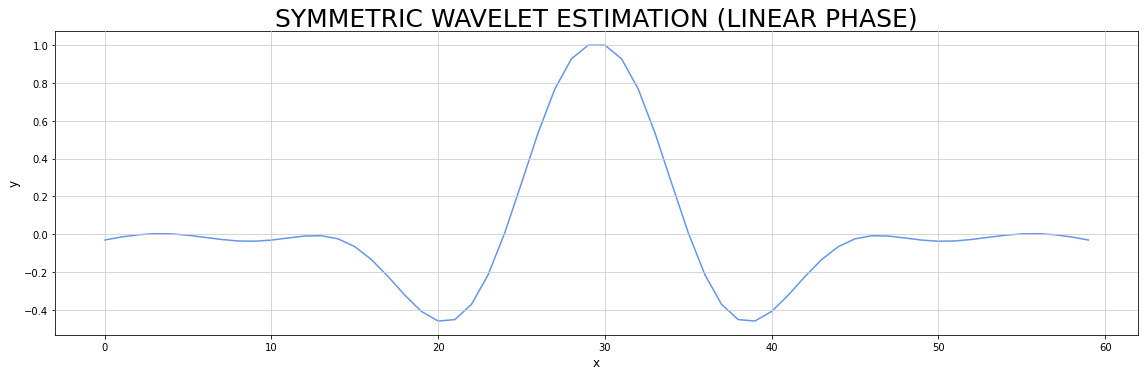

In [38]:
wavelet_0 = symmetric_wavelet_estimation(seismic_curve, wavelet_length=60)
plot(wavelet_0, mode='curve', title='SYMMETRIC WAVELET ESTIMATION (LINEAR PHASE)')

## Finding best shift

* Check out initial ranges of well time and seismic time to determine limits for shift

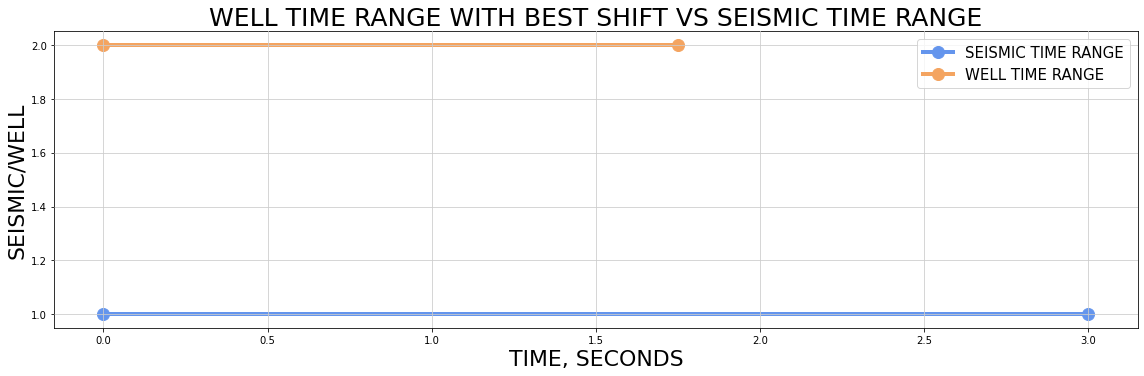

In [39]:
well.show_ranges(well_time, seismic_time)

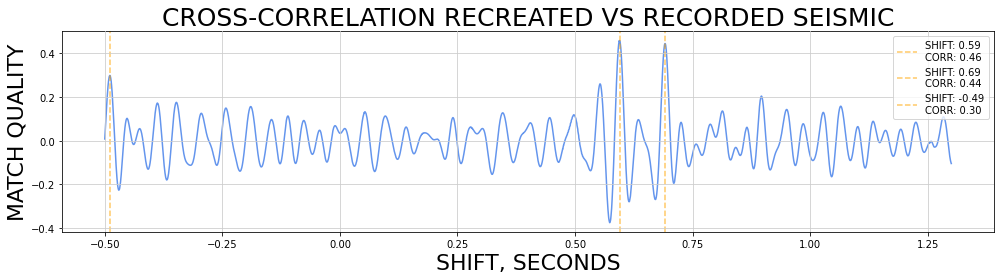

In [40]:
well.show_tie_crocccorrelation(seismic_time, well_time, seismic_curve, raw_impedance,
                               impulse=wavelet_0, limits=(-.5, 1.3), n_peaks=3)

* determine the best shift starting from a chosen point

In [41]:
# Note here that we took the second best option - because of visual preference
minimize(lambda shift: -well.measure_seismic_tie_quality(seismic_time, well_time + shift, seismic_curve, raw_impedance,
                                                         impulse=wavelet_0),
         0.69)

      fun: -0.4445896747852848
 hess_inv: array([[6.91392457e-06]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 38
      nit: 4
     njev: 19
   status: 0
  success: True
        x: array([0.69130848])

In [42]:
best_shift = 0.69130848

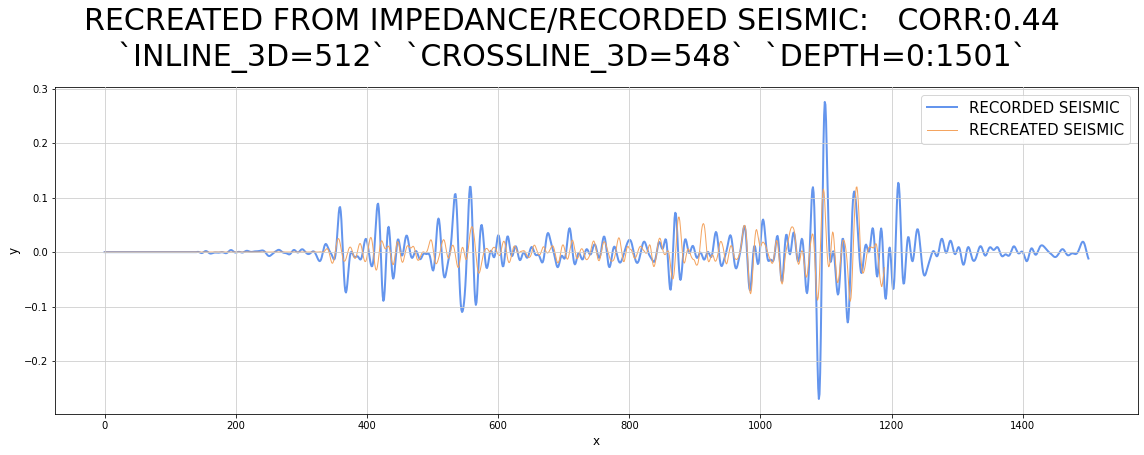

In [43]:
# Resample log and recreate synthetic utilizing the determined shift
# Use this plot to visually control the quality of the chosen shift
recreated = resample_and_compute_synthetic(seismic_time, well_time + best_shift, raw_impedance, impulse=wavelet_0)
correlation = well.nancorrelation(recreated, seismic_curve)

suptitle = (f'RECREATED FROM IMPEDANCE/RECORDED SEISMIC:   CORR:{correlation:.2f}\n`INLINE_3D={well_slice[0]}`  '
            f'`CROSSLINE_3D={well_slice[1]}`  `DEPTH={well_slice[2].start}:{well_slice[2].stop}`')

plot([seismic_curve, recreated], mode='curve',
     ratio=0.4, curve_linewidth=[2, 1, 1], suptitle=suptitle,
     label=['RECORDED SEISMIC', 'RECREATED SEISMIC'])

## Improve well-seismic tie (1) - optimize DTs to improve match

In [44]:
# Setting limits for scaling of deltas during optimization
bounds_multipliers = [0.96, 1.04]

In [46]:
# Select valid seismic time-slice [time-ticks where we can interpolate values of impedance-log]
clean_time_slice = well.get_relevant_seismic_slice(seismic_time, well_time + best_shift, raw_impedance)

In [47]:
# Run the optimization procedure to optimize ticks
# Select only the subset of seismic ticks - those we can recompute the synthetic in
# NOTE: we invert the impulse to ensure consistency between torch and numpy-convolution.
results = well.optimize_well_time(well_time + best_shift, seismic_time[clean_time_slice],
                                  seismic_curve[clean_time_slice], raw_impedance, impulse=wavelet_0[::-1].copy(),
                                  dt_bounds_multipliers=bounds_multipliers, n_iters=6000, optimizer='SGD',
                                  optimizer_kwargs={'lr': 5e-9})

/notebooks/notebooks/seismiqb_models/SEISMIC_WELL_TIE/../../../repos/seismiqb/seismiqb/labels/well/well_seismic_tie.py:93: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /opt/pytorch/pytorch/aten/src/ATen/native/Convolution.cpp:676.)
  return F.conv1d(reflectivity, impulse, padding='same').reshape(-1)


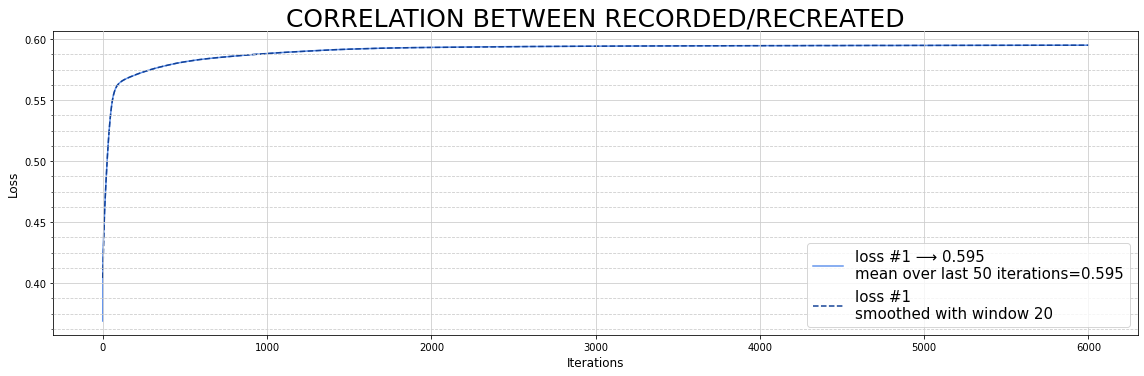

In [51]:
plot(-np.array(results[-1]),  mode='loss', title='CORRELATION BETWEEN RECORDED/RECREATED')

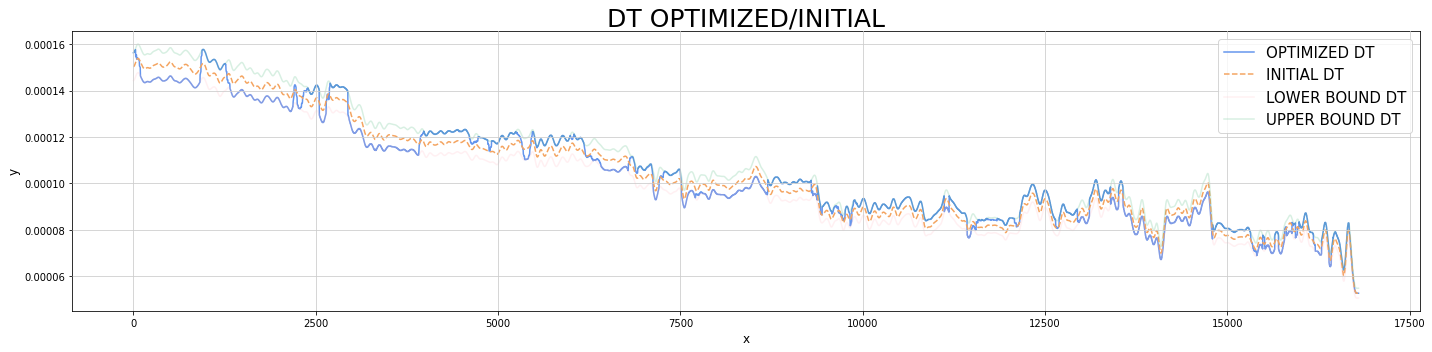

In [52]:
# Check out how DTs have changed during the optimization
dt_start = np.diff(well_time + best_shift)

plot([np.diff(results[0]), dt_start, dt_start * bounds_multipliers[0], dt_start * bounds_multipliers[1]],
     label=['OPTIMIZED DT', 'INITIAL DT', 'LOWER BOUND DT', 'UPPER BOUND DT'],
     mode='curve', figsize=(20, 5), curve_alpha=[1, 1, .2, .2], title='DT OPTIMIZED/INITIAL',
     curve_linestyle=['solid', 'dashed', 'solid', 'solid'])

In [53]:
# original
recreated1 = resample_and_compute_synthetic(seismic_time[clean_time_slice], well_time + best_shift,
                                            raw_impedance, impulse=wavelet_0)

# optimized
recreated2 = resample_and_compute_synthetic(seismic_time[clean_time_slice], results[0],
                                            raw_impedance, impulse=wavelet_0)

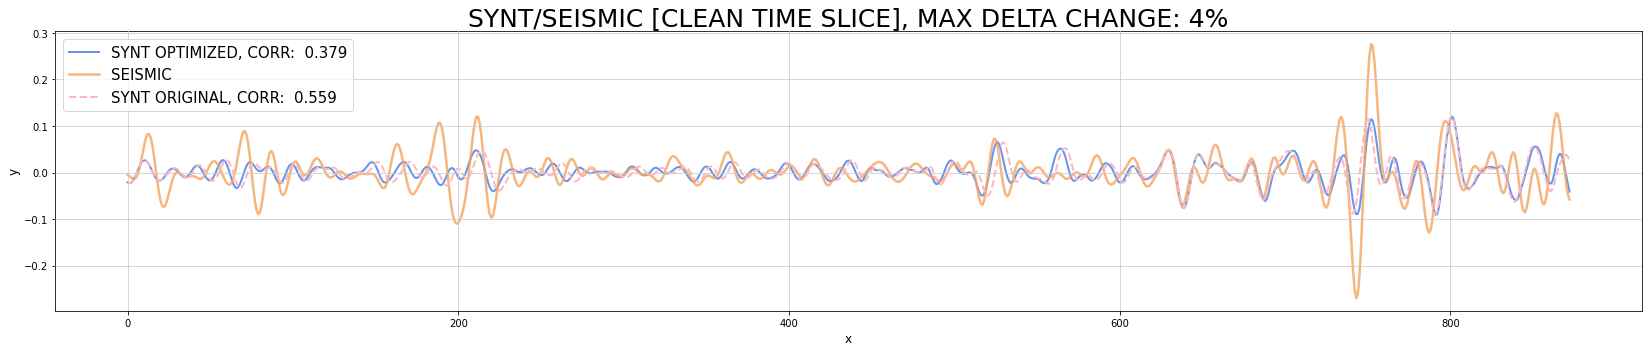

In [54]:
correlation1, correlation2 = [well.nancorrelation(recreated, seismic_curve[clean_time_slice]) for
                              recreated in [recreated1, recreated2]]

plot([recreated2, seismic_curve[clean_time_slice], recreated1], mode='curve',
     title=f'SYNT/SEISMIC [CLEAN TIME SLICE], MAX DELTA CHANGE: {(1 - bounds_multipliers[0])*100:.0f}%',
     label=[f'SYNT OPTIMIZED, CORR: {correlation1: .3f}', 'SEISMIC',
            f'SYNT ORIGINAL, CORR: {correlation2: .3f}'],
     figsize=(23, 5), curve_alpha=[1, .8, 1],
     curve_linestyle=['solid', 'solid', 'dashed'],
     curve_linewidth=[2, 2.5, 2])

In [55]:
# optimized well-ticks
well_time_1 = results[0]

## Improve the wavelet (1)

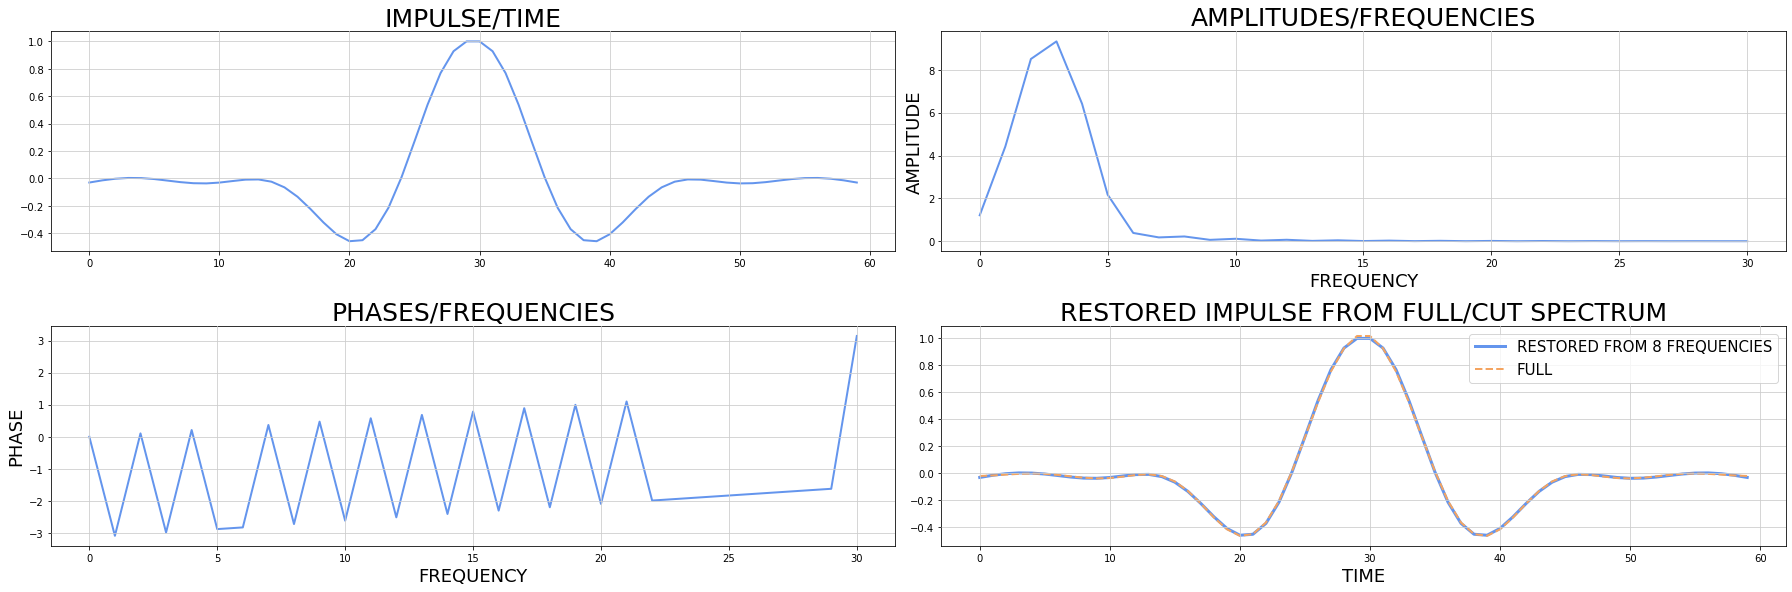

In [62]:
show_wavelet(wavelet_0)
# Use this plot to determine the allowed bounds for phases-optimization
# as well as the number of meaningful frequencies.
# If the wavelet can be reconstructed from, say, 7 frequencies - the rest of them can be safely ignored.

In [63]:
# select the parameters
cut_frequency = 8
delta=.9

In [64]:
optimization_factory = ImpulseOptimizationFactory(wavelet_0, seismic_time[clean_time_slice], well_time_1,
                                                  seismic_curve[clean_time_slice], raw_impedance, cut_frequency=cut_frequency,
                                                  delta=delta)

In [65]:
results = minimize(optimization_factory, optimization_factory.get_x0, bounds=optimization_factory.get_bounds)

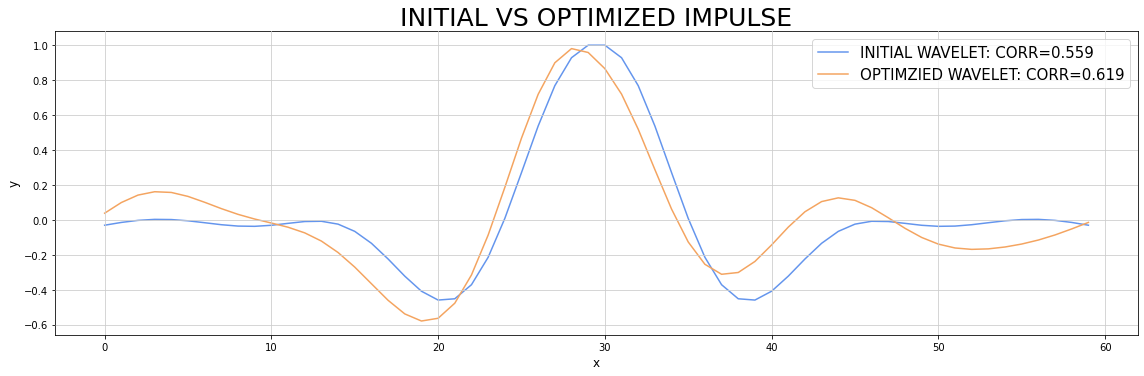

In [66]:
# Compare the original wavelet with the optimized one.
cut_frequency = 8
wavelet_1 = optimization_factory.compute_impulse(results['x'])

correlation2, correlation1 = -optimization_factory(results['x']), -optimization_factory(optimization_factory.get_x0)
plot([wavelet_0, wavelet_1], mode='curve',
     label=[f'INITIAL WAVELET: CORR={correlation1:.3f}', f'OPTIMZIED WAVELET: CORR={correlation2:.3f}'],
     title='INITIAL VS OPTIMIZED IMPULSE')

## Run several more iterations of [well_tie + wavelet-optimization]

In [ ]:
# Parameters of the procedure.
N_ITERS = 3   # The numbr
bounds_multipliers = [0.96, 1.04]
cut_frequency = 8
delta = .9

# Start well time and wavelet.
well_time = well_time_1
wavelet = wavelet_1

for _ in range(N_ITERS):
    # Optimize and update well-time ticks
    results = well.optimize_well_time(well_time, seismic_time[clean_time_slice],
                                      seismic_curve[clean_time_slice], raw_impedance, impulse=wavelet[::-1].copy(),
                                      dt_bounds_multipliers=bounds_multipliers, n_iters=6000, optimizer='SGD',
                                      optimizer_kwargs={'lr': 2e-9})
    well_time, loss_history = results

    # Optimize and update wavelet
    factory = ImpulseOptimizationFactory(wavelet, seismic_time[clean_time_slice], well_time,
                                         seismic_curve[clean_time_slice], raw_impedance,
                                         cut_frequency=cut_frequency, delta=delta)

    results = minimize(factory, factory.get_x0, bounds=factory.get_bounds)
    wavelet = optimization_factory.compute_impulse(results['x'])

* check out the final results: the optimized ticks and the wavelet

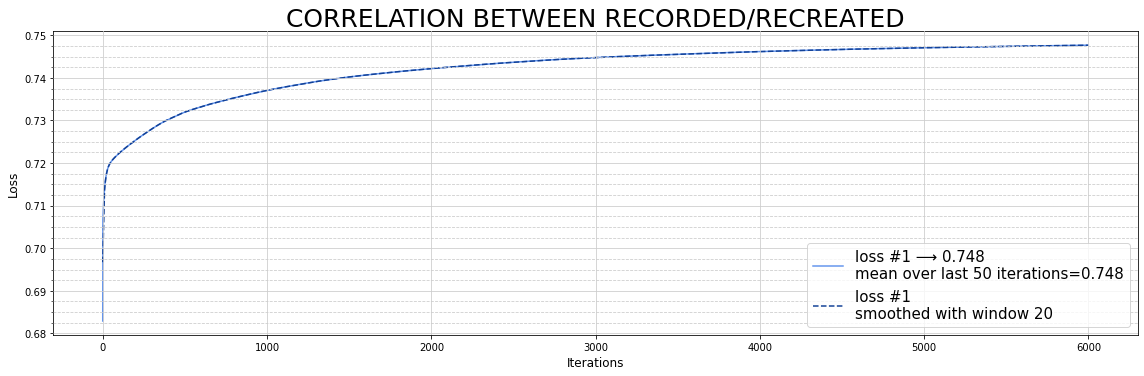

In [73]:
plot(-np.array(loss_history),  mode='loss', title='CORRELATION BETWEEN RECORDED/RECREATED')

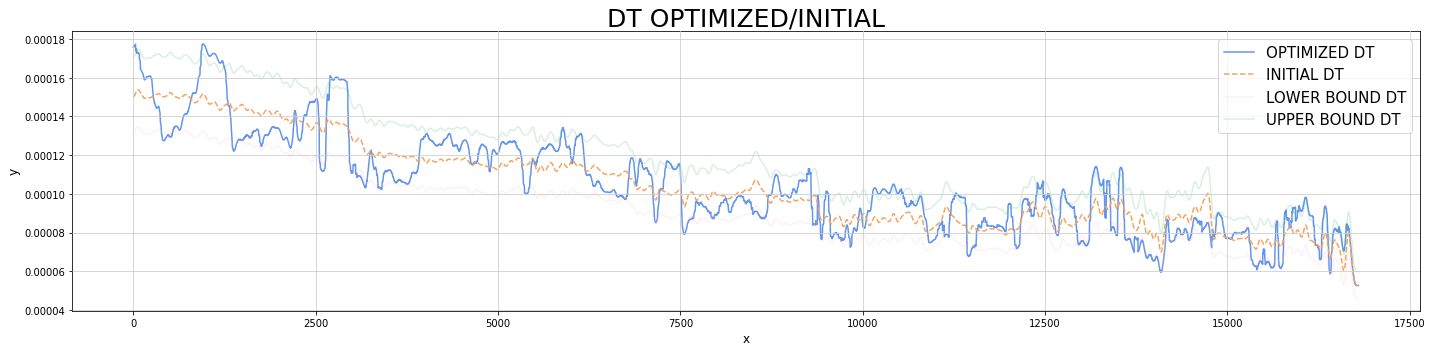

In [74]:
# Final well-time ticks
dt_start = well.DT_FILTERED.values * 1e-6

plot([np.diff(well_time), dt_start, dt_start * .96 * .97**3, dt_start * 1.04 * 1.03**3],
     label=['OPTIMIZED DT', 'INITIAL DT', 'LOWER BOUND DT', 'UPPER BOUND DT'],
     mode='curve', figsize=(20, 5), curve_alpha=[1, 1, .2, .2], title='DT OPTIMIZED/INITIAL',
     curve_linestyle=['solid', 'dashed', 'solid', 'solid'])

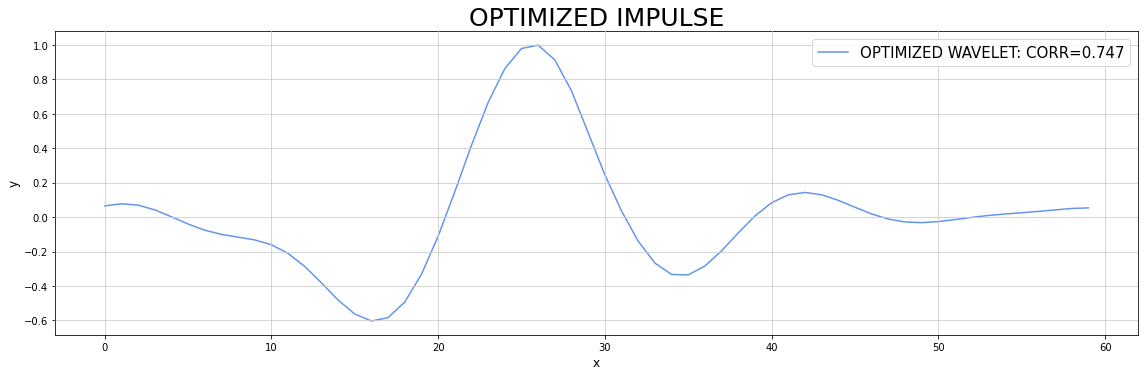

In [75]:
# Final wavelet
correlation = -factory(results['x'])
plot(wavelet, mode='curve', label=f'OPTIMIZED WAVELET: CORR={correlation:.3f}', title='OPTIMIZED IMPULSE')